In [2]:
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import opening, closing, disk

%matplotlib widget

### Save Disparity Values for Regression Line

In [15]:
left_ims = glob.glob('campus_regression_images/images/left*')
right_ims = glob.glob('campus_regression_images/images/right*')
masks = glob.glob('campus_regression_images/masks/*')

print(left_ims[0])
print(masks[0])

campus_regression_images/images\left_1.png
campus_regression_images/masks\mask_1.png


In [70]:
def computeDepthMap(imgL, imgR, mask):
    
        # ------------------------------------- #
        # SETUP
        # ------------------------------------- #
        imgL = cv2.GaussianBlur(imgL, (5,5), 0)
        imgR = cv2.GaussianBlur(imgR, (5,5), 0)

        # read camera data
        data = cv2.FileStorage('stereo_params.yml', cv2.FILE_STORAGE_READ)
        keys = ["K1", "K2", "D1", "D2", "R1", "R2", "P1", "P2", "T"]
        [K1, K2, D1, D2, R1, R2, P1, P2, T] = [data.getNode(key).mat() for key in keys]

        '''
        We know that

                |f  0   cx1  0|
        P1 =    |0  f   cy   0|
                |0  f   1    0|

        and 

                |f  0   cx2  Tx*f|
        P2 =    |0  f   cy   0   |
                |0  f   1    0   |

        and in our case, cx1 = cx2 = cx
        '''

        f = K1[0,0]
        Tx = T[0,0]
        P1 = np.hstack((K1, np.array([[0],[0],[0]])))
        P2 = np.hstack((K2, np.array([[Tx*f],[0],[0]])))


        # ------------------------------------- #
        # STEREO RECTIFICATION
        # ------------------------------------- #
        h1, w1 = imgL.shape

        # rectify images using initUndistortRectifyMap
        xmap1, ymap1 = cv2.initUndistortRectifyMap(K1, D1, R1, P1, (w1,h1), cv2.CV_32FC1)
        xmap2, ymap2 = cv2.initUndistortRectifyMap(K2, D2, R2, P2, (w1,h1), cv2.CV_32FC1)

        imgL_rectified = cv2.remap(imgL, xmap1, ymap1, cv2.INTER_LINEAR, cv2.BORDER_CONSTANT)
        imgR_rectified = cv2.remap(imgR, xmap2, ymap2, cv2.INTER_LINEAR, cv2.BORDER_CONSTANT)
        mask_rectified = cv2.remap(mask, xmap1, ymap1, cv2.INTER_LINEAR, cv2.BORDER_CONSTANT)

        # -------------------------------- #
        # COMPUTE DISPARITY MAP
        # -------------------------------- #

        # Matched blocked size
        window_size = 11
        min_disp = 0
        num_disp = 128-min_disp
        stereo = cv2.StereoSGBM_create(minDisparity = min_disp,
                numDisparities = num_disp,
                blockSize = window_size,
                uniquenessRatio = 10,
                speckleWindowSize = 100,
                speckleRange = 2,
                disp12MaxDiff = 5,
                P1 = 8*3*window_size**2,
                P2 = 32*3*window_size**2)
        
        right_matcher = cv2.ximgproc.createRightMatcher(stereo)

        # WLS Filter Parameters
        lmbda = 8000
        sigma=1.4
        visual_multiplier = 1.0

        wls_filter = cv2.ximgproc.createDisparityWLSFilter(matcher_left=stereo)
        wls_filter.setLambda(lmbda)
        wls_filter.setSigmaColor(sigma)

        # Compute the depth images
        disp = stereo.compute(imgL_rectified, imgR_rectified)
        dispL = disp
        dispR = right_matcher.compute(imgR_rectified, imgL_rectified)
        dispL = np.int16(dispL)
        dispR = np.int16(dispR)

        # Filtering with the WLS Filter
        filtered = wls_filter.filter(dispL, imgL_rectified, None, dispR)
        filtered = cv2.normalize(src=filtered, dst=filtered, beta=0, alpha=255, norm_type=cv2.NORM_MINMAX)
        filtered = np.uint8(filtered)

        disp = ((disp.astype(np.float32) / 16) - min_disp) / num_disp
        kernel= np.ones((3,3),np.uint8)
        # apply morphological closing to remove little black holes (removing noise)
        closing = cv2.morphologyEx(disp, cv2.MORPH_CLOSE, kernel)
        disp_closed = (closing - closing.min()) * 255
        disp_closed = disp_closed.astype(np.uint8)

        # mask the disparity maps
        filtered[mask_rectified == 0] = 0
        disp_closed[mask_rectified == 0] = 0
        
        return [disp_closed, filtered]


In [ ]:
left_img = cv2.imread('campus_regression_images/images/left_1.png', 0)
right_img = cv2.imread('campus_regression_images/images/right_1.png', 0)
mask = cv2.imread('campus_regression_images/masks/mask_1.png', 0)

depth = computeDepthMap(left_img, right_img, mask)

plt.figure()
plt.imshow(depth[0], 'gray')
plt.show()

In [96]:
def extract_disparities(left_ims, right_ims, masks):
    
    depth_maps = []
    raw_disparity_values = []
    filtered_disparity_values = []
    
    for left, right, msk in zip(left_ims, right_ims, masks):
        imgL = cv2.imread(left, 0)
        imgR = cv2.imread(right, 0)
        mask = cv2.imread(msk, 0)

        depth = computeDepthMap(imgL, imgR, mask)
        raw = depth[0][359:362, :]
        filtered = depth[1][359:362, :]
        
        # disparities are the median values
        r_disp = np.median(raw[np.nonzero(raw)])
        f_disp = np.median(filtered[np.nonzero(filtered)])

        # add the disparity values to their respective lists
        raw_disparity_values.append(r_disp)
        filtered_disparity_values.append(f_disp)

        # add the disparity maps to a list for returning
        depth_maps.append(depth)
    
    return {'D': depth_maps, 'R': np.array(raw_disparity_values), 'F': np.array(filtered_disparity_values)}

In [97]:
depths = extract_disparities(left_ims, right_ims, masks)

### Regression Line 2 (Short: <15m)

##### Rational Function

In [111]:
def disp2dist(x):
    '''
    Computes the distance given a disparity value between 0 & 255\n
    x must be a number or a numpy array
    The rational function was fitted using MATLAB's curveFitter App

    dist = np.linspace(2.0, 11.6, 33)
    disp = np.array([186, 207, 178, 129, 124, 113, 104, 168, 94, 88, 160, 97, 78, 73, 74, 
                 77, 66, 66, 62, 60, 108, 56, 94, 53, 51, 50, 49, 46, 45, 80, 44, 93, 41])
    '''
    return (507.7*pow(x,2) -214.7*x + 10.1) / (pow(x,3) + 76.2*pow(x,2) -3057*x - 139.7)

In [4]:
def fit_disp2dist(x):
    '''
    disp = [113, 113, 94, 89, 82, 77, 70, 70, 70, 65, 60, 55, 53, 51, 50, 49, 48, 46, 44, 
        42, 41, 40, 39, 38, 37, 36, 37, 36, 36, 34, 34, 33, 33]
    
    dist = np.linspace(3.0, 12.6, 33)
    '''
    y = (378*x**2 -1485*x - 76.37) / (x**3 + 6.802*x**2 - 400.3*x - 1003)
    return y

In [119]:
def disp_to_dist(x):
    '''
    Resolves the distance from a given disparity value based on a curve fitted to the \n
    following vales:

    disp = [119, 109, 101, 94, 87, 82, 77, 74, 71, 65, 63, 60, 57, 55, 52, 50, 48, 47, 45, 
            43, 42, 41, 40, 39, 38, 37, 37, 35, 35, 33, 33, 31, 31]

    dist = np.linspace(3.0, 12.6, 33)
    '''
    y = (346*x**2 -116.7*x - 1.961) / (x**3 - 5.863*x**2 + 47.24*x + 487.6)
    return y

In [ ]:
disp = [119, 109, 101, 94, 87, 82, 77, 74, 71, 65, 63, 60, 57, 55, 52, 50, 48, 47, 45, 
            43, 42, 41, 40, 39, 38, 37, 37, 35, 35, 33, 33, 31, 31]
dist = np.linspace(3.0, 12.6, 33)
x = np.linspace(31, 119, 880)
y = disp_to_dist(x)

plt.close()
plt.figure()
plt.scatter(disp, dist, label='Data')
plt.plot(x, y, 'r', label='Fit')
plt.xlabel('Disparity (pixels)')
plt.ylabel('Distance (m)')
plt.ylim(bottom=0, top=13)
plt.title('Distance vs Disparity')
plt.legend()
plt.show()

### Regression Line 3 (Long: Up to 35m)

In [5]:
def long_fit(value):
    '''
    Fits a polynomial to a scatter plot of points for distance/disparity relationship
    for up to 35m length.
    '''
    dist = np.arange(2, 28, 1)
    disp = np.array([215, 188, 174, 164, 159, 155, 152, 150, 152, 146, 
                    145, 143, 144, 141, 141, 141, 140, 140, 140, 139, 139, 139, 142, 138, 139, 137])
    model = np.poly1d(np.polyfit(disp, dist, 6))
    
    return model(value)


### Top, base, Left and Right Extreme Pixels

In [156]:
def convex_hull(img):
    '''
    Finds the tip pixels on the left, right, base and top of the image
    '''
    rows, cols = img.nonzero()
    base = (rows.max(), cols[np.where(rows == rows.max())][0])
    top =  (rows.min(), cols[np.where(rows == rows.min())][0])
    left =  (rows[np.where(cols == cols.min())][0], cols.min())
    right = (rows[np.where(cols == cols.max())][0], cols.max())
   
    return base, top, left, right

In [201]:
def compute_bh(img, zc, baseline=0.129, f=1438):
    '''
    Computes the number of pixels from the trunk base breast height of the tree
    @ img: Source image
    @ zc: Real world depth of trunk base
    '''
    disparity = baseline * f / zc
    base = convex_hull(img)[0]
    xc = baseline * (base[0] - 360) / disparity
    yc = baseline * (base[1] - 640) / disparity

    # applying the geometry for deriving the position of the breast height
    dg = np.sqrt(xc**2 + yc**2 + zc**2)
    phi = np.arctan(yc / zc)
    beta = (np.pi/2 - phi)
    dh = np.sqrt(1.69 + dg**2 - 2.6*dg*np.cos(beta))
    theta = np.arcsin(1.3 * np.sin(beta) / dh)
    sh = 2822.61 * np.tan(theta/2) # no. of pixels from base to the breast height (1.3m above the ground)
    bh = base[0] - np.int64(sh) # row number where breast height is found
    
    return bh
    

In [146]:
def plot_bh(img, bh):
    
    plt.figure(figsize=(8,3))
    plt.imshow(img, 'gray')
    plt.hlines(bh, 0, 1279, colors='r')
    plt.show()

In [148]:
def compute_dbh(sd, da):
    theta = np.arctan(sd * 3.546e-4)
    D = 2 * da * np.tan(theta)
    return D

In [151]:
def median_top_pixel(image):
    pixels = []
    top = convex_hull(image)[1]

    sub_image = image[top[0] : top[0] + 21, :]
    rows, columns = np.nonzero(sub_image)
    for row, column in zip(rows, columns):
        pixels.append(sub_image[row, column])
    
    # print(pixels)
    pixels = np.array(pixels)

    return np.median(pixels)

In [218]:
def median_base_pixel(image):
    pixels = []
    base = convex_hull(image)[0]

    sub_image = image[base[0] - 50 : base[0] + 1, :]
    rows, columns = np.nonzero(sub_image)
    for row, column in zip(rows, columns):
        pixels.append(sub_image[row, column])

    # print(pixels)
    pixels = np.array(pixels)

    return np.median(pixels)

In [230]:
def median_bh_pixels(image):

    pixels = []
    zc = disp_to_dist(median_base_pixel(image))
    bh = compute_bh(image, zc)
    sub_image = image[bh - 5 : bh + 5, :]

    rows, columns = np.nonzero(sub_image)
    for row, column in zip(rows, columns):
        pixels.append(sub_image[row, column])
    
    pixels = np.array(pixels)
    half_pixels = np.array_split(pixels, 2)
    center = np.median(pixels)
    edge = np.median(half_pixels[0])

    return [center, edge]

In [219]:
def minimum_crown_pixel(image):
    pixels = []
    left = convex_hull(image)[2]

    sub_image = image[:, left[1] : left[1] + 21]
    rows, columns = np.nonzero(sub_image)
    for row, column in zip(rows, columns):
        pixels.append(sub_image[row, column])

    # print(pixels)
    pixels = np.array(pixels)

    return int(np.mean(pixels))

In [220]:
def pixel_of_interest(image, parameter:str):
    '''
    Returns the value of the pixel of interest depending on the parameter chosen
    '''
    if parameter.lower() == 'dbh':
        return median_base_pixel(image)
            
    elif parameter.lower() == 'th':
        base = median_base_pixel(image)
        top = median_top_pixel(image)
        return [base, top]
    
    elif parameter.lower() == 'cd':
        return minimum_crown_pixel(image)

    else:
        raise TypeError("Invalid parameter. Must be 'dbh', 'th', or 'cd' ")

In [270]:
def computeDepthMap(imgL, imgR, mask):
    
        # ------------------------------------- #
        # SETUP
        # ------------------------------------- #
        imgL = cv2.GaussianBlur(imgL, (5,5), 0)
        imgR = cv2.GaussianBlur(imgR, (5,5), 0)

        # read camera data
        data = cv2.FileStorage('stereo_params_v2.yml', cv2.FILE_STORAGE_READ)
        keys = ["K1", "K2", "D1", "D2", "R1", "R2", "P1", "P2", "T"]
        [K1, K2, D1, D2, R1, R2, P1, P2, T] = [data.getNode(key).mat() for key in keys]

        '''
        We know that

                |f  0   cx1  0|
        P1 =    |0  f   cy   0|
                |0  f   1    0|

        and 

                |f  0   cx2  Tx*f|
        P2 =    |0  f   cy   0   |
                |0  f   1    0   |

        and in our case, cx1 = cx2 = cx
        '''

        f = K1[0,0]
        Tx = T[0,0]
        P1 = np.hstack((K1, np.array([[0],[0],[0]])))
        P2 = np.hstack((K2, np.array([[Tx*f],[0],[0]])))


        # ------------------------------------- #
        # STEREO RECTIFICATION
        # ------------------------------------- #
        h1, w1 = imgL.shape

        # rectify images using initUndistortRectifyMap
        xmap1, ymap1 = cv2.initUndistortRectifyMap(K1, D1, R1, P1, (w1,h1), cv2.CV_32FC1)
        xmap2, ymap2 = cv2.initUndistortRectifyMap(K2, D2, R2, P2, (w1,h1), cv2.CV_32FC1)

        imgL_rectified = cv2.remap(imgL, xmap1, ymap1, cv2.INTER_LINEAR, cv2.BORDER_CONSTANT)
        imgR_rectified = cv2.remap(imgR, xmap2, ymap2, cv2.INTER_LINEAR, cv2.BORDER_CONSTANT)
        mask_rectified = cv2.remap(mask, xmap1, ymap1, cv2.INTER_LINEAR, cv2.BORDER_CONSTANT)

        # -------------------------------- #
        # COMPUTE DISPARITY MAP
        # -------------------------------- #

        # Matched blocked size
        window_size = 11
        min_disp = 0
        num_disp = 128-min_disp
        stereo = cv2.StereoSGBM_create(minDisparity = min_disp,
                numDisparities = num_disp,
                blockSize = window_size,
                uniquenessRatio = 10,
                speckleWindowSize = 100,
                speckleRange = 2,
                disp12MaxDiff = 5,
                P1 = 8*3*window_size**2,
                P2 = 32*3*window_size**2)
        
        right_matcher = cv2.ximgproc.createRightMatcher(stereo)

        # WLS Filter Parameters
        lmbda = 8000
        sigma=1.4
        visual_multiplier = 1.0

        wls_filter = cv2.ximgproc.createDisparityWLSFilter(matcher_left=stereo)
        wls_filter.setLambda(lmbda)
        wls_filter.setSigmaColor(sigma)

        # Compute the depth images
        disp = stereo.compute(imgL_rectified, imgR_rectified)
        dispL = disp
        dispR = right_matcher.compute(imgR_rectified, imgL_rectified)
        dispL = np.int16(dispL)
        dispR = np.int16(dispR)

        # Filtering with the WLS Filter
        filtered = wls_filter.filter(dispL, imgL_rectified, None, dispR)
        filtered = cv2.normalize(src=filtered, dst=filtered, beta=0, alpha=255, norm_type=cv2.NORM_MINMAX)
        filtered = np.uint8(filtered)

        disp = ((disp.astype(np.float32) / 16) - min_disp) / num_disp
        kernel= np.ones((3,3),np.uint8)
        # apply morphological closing to remove little black holes (removing noise)
        closing = cv2.morphologyEx(disp, cv2.MORPH_CLOSE, kernel)
        disp_closed = (closing - closing.min()) * 255
        disp_closed = disp_closed.astype(np.uint8)

        # mask the disparity maps
        # filtered[mask_rectified == 0] = 0
        # disp_closed[mask_rectified == 0] = 0
        
        return {'R': disp_closed, 'F': filtered}


In [292]:
def rectify_image(image):

        data = cv2.FileStorage('stereo_params_v2.yml', cv2.FILE_STORAGE_READ)
        keys = ["K1", "K2", "D1", "D2", "R1", "R2", "P1", "P2", "T"]
        [K1, K2, D1, D2, R1, R2, P1, P2, T] = [data.getNode(key).mat() for key in keys]

        f = K1[0,0]
        Tx = T[0,0]
        P1 = np.hstack((K1, np.array([[0],[0],[0]])))
        P2 = np.hstack((K2, np.array([[Tx*f],[0],[0]])))

        h1, w1 = image.shape

        # rectify images using initUndistortRectifyMap
        xmap1, ymap1 = cv2.initUndistortRectifyMap(K1, D1, R1, P1, (w1,h1), cv2.CV_32FC1)
        image_rectified = cv2.remap(image, xmap1, ymap1, cv2.INTER_LINEAR, cv2.BORDER_CONSTANT)

        return image_rectified

In [221]:
def show_dbh(image, measured_dbh):
    '''
    This function assembles all information on the diameter at breast height for display. \n
    1. Distance to the base \n
    2. No. of pixels from top to breast height \n
    3. Plotting the breast height location \n
    4. No. of pixels that the DBH spans \n
    5. Displaying extracted DBH value \n
    6. Displaying % error in DBH extraction \n
    '''
    
    base_px = pixel_of_interest(image, 'dbh')
    base_depth = disp_to_dist(base_px)
    bh = compute_bh(image, zc=base_depth)
    plot_bh(image, bh)
    print(f"Trunk base depth: {round(base_depth, 2)}m")
    print(f"Breast Height Location: {bh} pixels from the top")
    px = np.nonzero(image[bh, :])[0]
    sz = px.size
    print(f"The DBH spans {sz} pixels")
    da = disp_to_dist(median_bh_pixels(image)[1])
    print(f"Depth of breast height: {round(da, 2)}m")
    D = compute_dbh(sz, da)
    print(f"Extracted DBH: {round(D*100, 2)}cm")
    print(f"Measured DBH: {round(measured_dbh*100, 2)}cm")
    p_error = np.abs(D - measured_dbh)/measured_dbh * 100
    print(f"Error: {round(p_error, 2)}%")


In [271]:
left_ims = glob.glob('trunks/images/left_*.png')
right_ims = glob.glob('trunks/images/right_*.png')
masks = glob.glob('trunks/masks/mask_*.png')

In [272]:
def save_depth_maps(left_ims, right_ims, masks):

    zipped = zip(left_ims, right_ims, masks)
    for left, right, mask in zipped:
        imgL = cv2.imread(left, 0)
        imgR = cv2.imread(right, 0)
        maskL = cv2.imread(mask, 0)

        depth = computeDepthMap(imgL, imgR, maskL)
        i = left.split('\\')[1].split('_')[1].split('.')[0]

        cv2.imwrite('trunks/full_dmaps/fullmap_' + i + '.png', depth['R'])
        # cv2.imwrite('full_trees/filtered_dmaps/filtered_' + i + '.png', depth['F'])

    print("All depth maps have been saved.")

In [273]:
save_depth_maps(left_ims, right_ims, masks)

All depth maps have been saved.


In [ ]:
# ------------------------------------- #
# LOAD IMAGES
# ------------------------------------- #
imgL = cv2.imread('trunks/images/left_1.png', 0)
imgR = cv2.imread('trunks/images/right_1.png', 0)
mask = cv2.imread('trunks/masks/mask_1.png', 0)

depth = computeDepthMap(imgL, imgR, mask)

plt.close()
plt.figure(figsize=(10,4))
plt.imshow(depth['R'], 'gray')
plt.show()

##### 1. Load the Disparity Map and Show BH Location

In [ ]:
dmap = cv2.imread('trunks/raw_depthmaps/raw_1.png', 0)
zc = disp_to_dist(median_base_pixel(dmap))
bh = compute_bh(dmap, zc)
plot_bh(dmap, bh)

##### 2. Perform Morphological Operation on Mask if Necessary

In [ ]:
mask = cv2.imread('trunks/masks/mask_1.png', 0)
kernel = np.ones((50, 1), np.uint8)
closing = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
opening = cv2.morphologyEx(closing, cv2.MORPH_OPEN, kernel)

plt.figure()
plt.imshow(opening, 'gray')
plt.show()

##### 3. Rectify Mask and Apply it on Full Disparity Map

In [310]:
opening = rectify_image(opening)
dmap = cv2.imread('trunks/full_dmaps/fullmap_1.png', 0)
dmap[opening == 0] = 0
# cv2.imwrite('trunks/raw_depthmaps/raw_1.png', dmap)

##### 5. Extract the DBH and Record It

In [ ]:
show_dbh(dmap, 0.896/np.pi)

#### CD & TH Extraction

In [54]:
def compute_cd(image, baseline=0.129, f=1438):
    '''
    This function extracts the crown diameter from a segmented depth map
    '''

    left, right = convex_hull(image)[2:4]
    crown_px = minimum_crown_pixel(image)
    
    z = fit_disp2dist(crown_px)
    disparity = baseline * f / z
    x = baseline * (left[0] - 360) / disparity
    y = baseline * (left[1] - 640) / disparity
    print(f"Real word coordinates: {round(x, 2), round(y, 2), round(z, 2)}")

    sc = right[1] - left[1]
    da = np.sqrt(x**2 + y**2 + z**2)
    theta = 2 * np.arctan(sc * 3.546e-4)
    D = 2 * da * np.tan(theta/2)

    print(f"Left crown extreme is {round(da, 2)}m away")
    print(f"CD: {round(D, 2)}m")

    plt.figure()
    plt.imshow(image, 'gray')
    plt.vlines([left[1], right[1]], 0, 719)
    plt.show()

Real word coordinates: (-3.09, -6.22, 36.36)
Left crown extreme is 37.02m away
CD: 14.44m


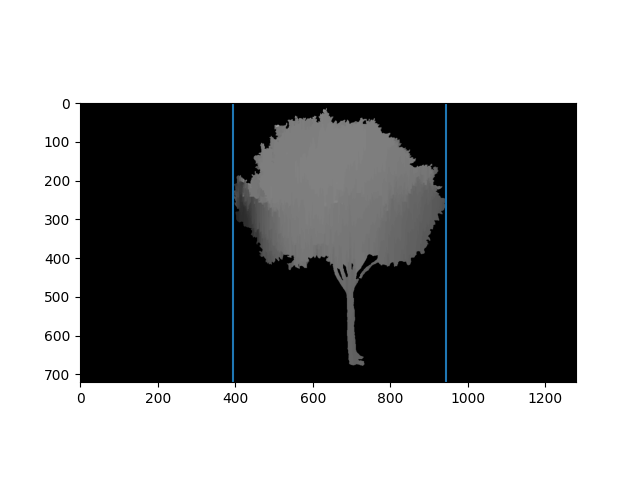

In [69]:
compute_cd(depth)

In [36]:
def compute_th(image, baseline=0.129, f=1438):
    '''
    This function extracts the crown diameter from a segmented depth map
    '''

    base, top = convex_hull(image)[0:2]
    base_px = median_base_pixel(image)
    top_px = median_top_pixel(image)
    
    zb = fit_disp2dist(base_px)
    disparity = baseline * f / zb
    xb = baseline * (base[0] - 360) / disparity
    yb = baseline * (base[1] - 640) / disparity
    print(f"Real world coordinates of base: {round(xb, 2), round(yb, 2), round(zb, 2)}")

    zt = fit_disp2dist(top_px)
    disparity = baseline * f / zt
    xt = baseline * (top[0] - 360) / disparity
    yt = baseline * (top[1] - 640) / disparity
    print(f"Real world coordinates of top: {round(xt, 2), round(yt, 2), round(zt, 2)}")    

    st = base[0] - top[0]
    db = np.sqrt(xb**2 + yb**2 + zb**2)
    dt = np.sqrt(xt**2 + yt**2 + zt**2)
    phi = np.arctan(zb / yb)
    theta = 2 * np.arctan(st * 3.543e-4)
    H = dt * np.sin(theta) / np.sin(phi)

    print(f"Tree base is {round(db, 2)}m away")
    print(f"Tree top is {round(dt, 2)}m away")
    print(f"TH: {round(H, 2)}m")

    plt.figure()
    plt.imshow(image, 'gray')
    plt.hlines([base[0], top[0]], 0, 1279)
    plt.show()

Real world coordinates of base: (2.55, 0.2, 10.89)
Real world coordinates of top: (-0.74, 0.21, 3.4)
Tree base is 11.19m away
Tree top is 3.49m away
TH: 1.52m


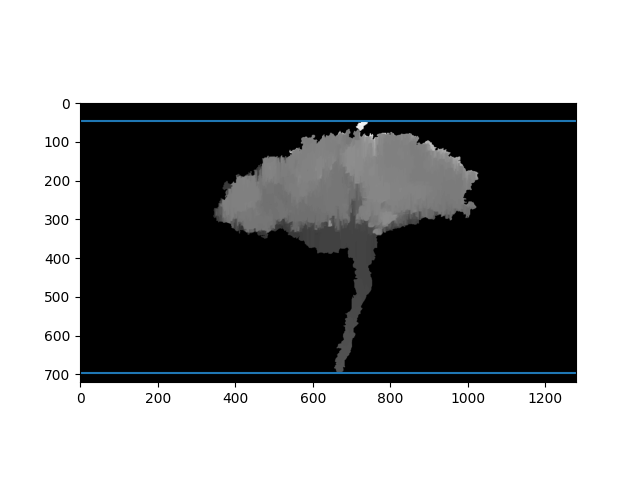

In [32]:
# whole_depth = cv2.imread('area/masked/masked_10.png', 0)
compute_th(depth)

#### Normalized Cut Segmentation

In [36]:
fit_disp2dist(43)

8.596288612018428

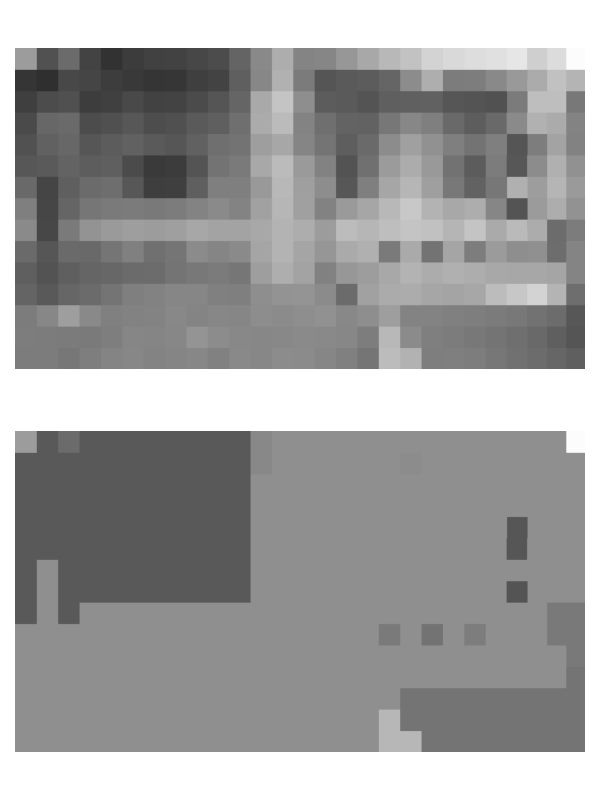

In [11]:
from skimage import data, segmentation, color
from skimage.future import graph
from matplotlib import pyplot as plt


img = imgL

labels1 = segmentation.slic(img, compactness=30, n_segments=400,
                            start_label=1)
out1 = color.label2rgb(labels1, img, kind='avg', bg_label=0)

g = graph.rag_mean_color(img, labels1, mode='similarity')
labels2 = graph.cut_normalized(labels1, g)
out2 = color.label2rgb(labels2, img, kind='avg', bg_label=0)

fig, ax = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(6, 8))

ax[0].imshow(out1)
ax[1].imshow(out2)

for a in ax:
    a.axis('off')

plt.tight_layout()